# Testing GOAT
Pranav Mathur

In [1]:
import numpy as np
from numpy.polynomial import chebyshev
import matplotlib.pyplot as plt
from goat_optimization import run_goat_optimization
from qutip_gate_simulation import data_from_tstep, simulate_gate, calculate_fidelity
from scipy.optimize import NonlinearConstraint

## Rydberg Gates

In [2]:
# define hamiltonians
H0 = np.zeros((4, 4))

H_plus = np.array([[0, 0, 1/2, 0],
                   [0, 0, 0, np.sqrt(2)/2],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])
H_minus = np.array([[0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [1/2, 0, 0, 0],
                    [0, np.sqrt(2)/2, 0, 0]])
H_controls = [H_plus, H_minus]

U_target = np.array([[1, 0],
                     [0, -1]])

In [3]:
# define control functions
def to_control_func_plus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(1j * alpha[j])

def to_control_func_minus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])

def to_control_param_derivs(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    deriv_matrix[0][j] = 1j * control_extra_params["Omega_max"] * np.exp(1j * alpha[j])
    deriv_matrix[1][j] = -1j * control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])
    return deriv_matrix

def chebyshev_control_func_plus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( 1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_func_minus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( -1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_param_derivs(t, alpha, control_extra_params=None):
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    phase = chebyshev.chebval((2/control_extra_params["t_max"])*t-1, alpha)
    plus_exp_val = 1j * control_extra_params["Omega_max"] * np.exp(1j * phase)
    minus_exp_val = -1j * control_extra_params["Omega_max"] * np.exp(-1j * phase)
    for i in range(alpha.size):
        c = np.zeros(alpha.size)
        c[i] = 1
        deriv_matrix[0][i] = plus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
        deriv_matrix[1][i] = minus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
    return deriv_matrix

# control_funcs = [to_control_func_plus, to_control_func_minus]
# control_param_derivs = to_control_param_derivs
control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

def U_truncator(U_full):
    if U_full.ndim == 2:
        return U_full[0:2, 0:2]
    else:
        return U_full[:, 0:2, 0:2]

In [10]:
# initial values of piecewise controls
def load_pulse_profile_from_csv(filename):
    gate_parameters = np.genfromtxt(filename, delimiter=',', skip_header=1, filling_values=np.nan)
    t_min = gate_parameters[0, 0]
    t_max = gate_parameters[-2, 0]
    t_steps = gate_parameters[:-1, 0]
    drive_strengths = gate_parameters[:-1, 1]
    phases = gate_parameters[:-1, 2]

    return t_min, t_max, t_steps, drive_strengths, phases

t_min, t_max, t_steps, drive_strengths, phases = load_pulse_profile_from_csv("./pulses/01_cz.csv")
t_span = [t_min, t_max]
n_pieces = phases.size
alpha0 = np.concatenate((phases, [0]))

# custom initial values

# t_max = 7.612 # from TO gates paper
# n_pieces = 100
# t_span = [0, t_max]

# # alpha0 = np.random.uniform(low=np.pi/2, high=(3/2)*np.pi, size=n_pieces+1)
# alpha0 = 0.3 * np.ones(n_pieces + 1) 
# # alpha0 = np.zeros(n_pieces + 1)
# # alpha0 = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=n_pieces+1)

# alpha_bounds = np.tile([0, 2*np.pi], (n_pieces + 1, 1)) 
alpha_bounds = np.tile([-np.pi, np.pi], (n_pieces + 1, 1)) 

In [4]:
# initial values of chebyshev controls
t_min = 0
t_max = 7.612 # from TO gates paper TODO: try lower gate time
t_span = [t_min, t_max]

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

In [5]:
# control extra parameters and callback functions
control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max,
    # "n_pieces": n_pieces
}

# approximate maximum of chebyshev series
def chebyshev_max(coeffs):
    N = coeffs.size - 1
    K = 4 * N
    x = np.cos(np.pi * np.arange(K+1) / K) # chebyshev points
    f = chebyshev.chebval(x, coeffs)
    return np.max(f)    
chebyshev_constraint = NonlinearConstraint(chebyshev_max, -np.pi, np.pi)

prev_params = []
def callback(x):
    prev_params.append(np.copy(x))

In [22]:
# import cProfile
# import pstats

# profiler = cProfile.Profile()
# profiler.enable()

res = run_goat_optimization(
    H0,
    H_controls,
    control_funcs,
    control_param_derivs,
    alpha0,
    U_target,
    t_span,
    U_truncator,
    fidelity_func_name="GOAT",
    # alpha_bounds=alpha_bounds,
    constraints=chebyshev_constraint,
    single_qubit_phase_weights=[1, 2],
    control_extra_params=control_extra_params,
    callback=callback
)

# profiler.disable()
# stats = pstats.Stats(profiler)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24528D-01    |proj g|=  4.37915D-01

At iterate    1    f=  3.71115D-01    |proj g|=  3.41056D-01

At iterate    2    f=  2.90150D-01    |proj g|=  3.99572D-01

At iterate    3    f=  1.98523D-01    |proj g|=  2.21749D-01

At iterate    4    f=  7.70511D-02    |proj g|=  1.79197D-01

At iterate    5    f=  9.64583D-03    |proj g|=  8.99291D-02

At iterate    6    f=  4.68631D-03    |proj g|=  5.04762D-02

At iterate    7    f=  2.23096D-03    |proj g|=  2.99984D-02

At iterate    8    f=  8.64646D-04    |proj g|=  9.28770D-03

At iterate    9    f=  3.03142D-04    |proj g|=  9.73270D-03

At iterate   10    f=  1.54930D-04    |proj g|=  3.00334D-03

At iterate   11    f=  9.47913D-05    |proj g|=  2.28326D-03

At iterate   12    f=  4.13937D-05    |proj g|=  5.56372D-03

At iterate   13    f=  2.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   27    f=  2.00784D-10    |proj g|=  9.30213D-09



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     28     97      3     0     0   9.302D-09   2.008D-10
  F =   2.0078361195885464E-010

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [19]:
# load previous run data
import pickle

with open("results/goat_run_12.pkl", "rb") as file:
    (res, prev_params) = pickle.load(file)

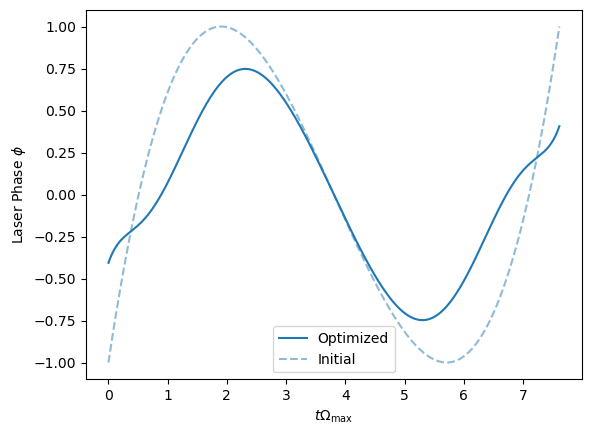

In [23]:
# plot piecewise-continouous gate
# plt.step(np.linspace(0, t_max, n_pieces), res.x[:-1], color="tab:blue", label="Optimized")
# plt.step(np.linspace(0, t_max, n_pieces), alpha0[:-1], alpha=0.35, label="Initial")
# plt.xlabel("$t\\Omega_{\\text{max}}$")
# plt.ylabel("Laser Phase $\\phi$")
# plt.legend()

# plot chebyshev gate
ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, res.x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

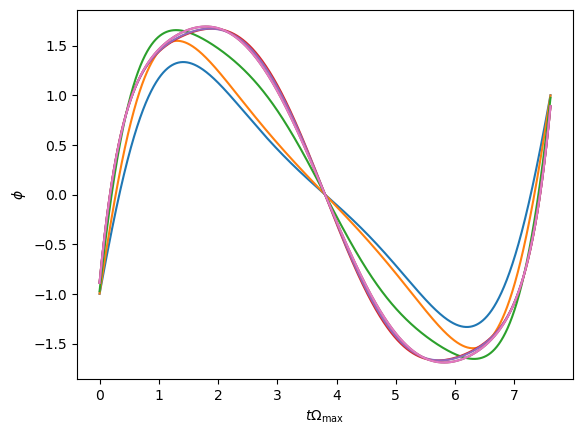

In [9]:
# plot how gate changed during optimization
for i in range(len(prev_params)):
    # plt.step(np.linspace(0, t_max, n_pieces), prev_params[i][:-1], alpha=0.3, label=f"{i}")

    ts = np.linspace(0, t_max, 10001)
    plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, prev_params[i][:-1]))
# plt.step(np.linspace(0, t_max, 100), prev_params[-2][:-1], alpha=0.3) # , label=f"{i}")
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("$\\phi$")
# plt.legend()
plt.show()

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


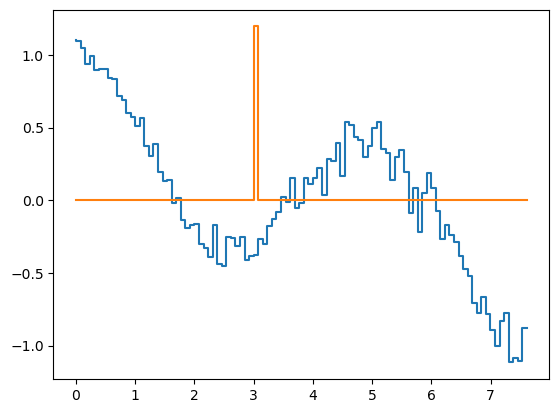

In [6]:
# check that piecewise controls are working
nts = 100
ts = np.linspace(0, t_max, nts)
controls = np.zeros(nts)
control_derivs = np.zeros(nts, dtype=complex)
deriv_j = 40
for i in range(nts):
    cval = to_control_func_plus(ts[i], res.x[:-1], control_extra_params)
    # print(cval)
    controls[i] = np.angle(cval)

    c_derivs = control_param_derivs(ts[i], res.x[:-1], control_extra_params)
    # print(c_derivs)
    control_derivs[i] = np.angle(c_derivs[0][deriv_j])

plt.step(ts, controls)
plt.step(ts, control_derivs)
plt.show()

F = 0.9997975884027972


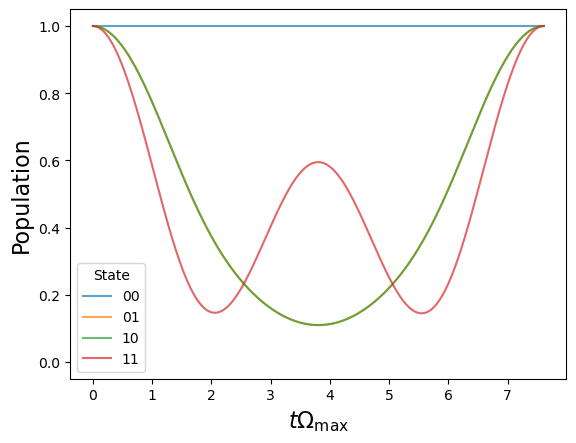

In [24]:
# simulate resulting gate in qutip
to_drive_strength_func = lambda t: 1
to_phase_func = lambda t: data_from_tstep(t, t_steps, res.x[:-1])

chebyshev_drive_strength_func = lambda t: 1
chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, res.x[:-1])

results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001)
# results = simulate_gate(to_drive_strength_func, to_phase_func, 100, 0, t_min, t_max, 1001)
print(f"F = {calculate_fidelity(results, single_qubit_phase=res.x[-1])}")
plt.show()

-2.150085900238149
-2.1413095526868027
0.9998296602128983


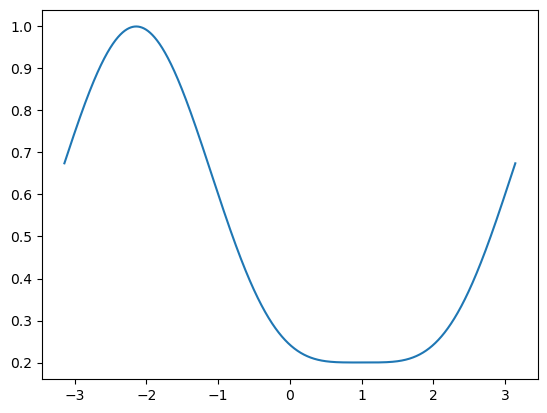

In [13]:
N = 10001
phases = np.linspace(-np.pi, np.pi, N)
fidelities = np.zeros(N)

for i in range(N):
    fidelities[i] = calculate_fidelity(results, single_qubit_phase=phases[i])
print(res.x[-1])
print(phases[np.argmax(fidelities)])
print(np.max(fidelities))

plt.plot(phases, fidelities)
plt.show()

## Sweep Gate Time

In [6]:
n_times = 26
gate_times = np.linspace(5, 10, n_times)
goat_results = []
fidelities = np.zeros(n_times)

control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

for i in range(n_times):
    print(f"Gate time: {gate_times[i]}")
    t_min = 0
    t_max = 7.612 # from TO gates paper 
    t_span = [t_min, t_max]

    control_extra_params = {
        "Omega_max": 1,
        "t_max": gate_times[i],
        # "n_pieces": n_pieces
    }

    res = run_goat_optimization(
        H0,
        H_controls,
        control_funcs,
        control_param_derivs,
        alpha0,
        U_target,
        t_span,
        U_truncator,
        fidelity_func_name="GOAT",
        # alpha_bounds=alpha_bounds,
        constraints=chebyshev_constraint,
        single_qubit_phase_weights=[1, 2],
        control_extra_params=control_extra_params,
        callback=callback
    )

    goat_results.append(res)
    fidelities[i] = res.fun

Gate time: 5.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35650D-01    |proj g|=  8.53027D+01


/Users/pranav/Documents/School/Princeton/Thesis/noise-robust-gates/goat_optimization.py:199: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  res = minimize(
 This problem is unconstrained.



At iterate    1    f=  8.24968D-01    |proj g|=  1.60164D+00

At iterate    2    f=  8.24725D-01    |proj g|=  2.35291D-01

At iterate    3    f=  8.19982D-01    |proj g|=  2.75087D-01

At iterate    4    f=  8.19530D-01    |proj g|=  2.35946D-01

At iterate    5    f=  8.18180D-01    |proj g|=  3.97374D-01

At iterate    6    f=  8.13283D-01    |proj g|=  1.97627D+00

At iterate    7    f=  8.13091D-01    |proj g|=  6.52087D-01

At iterate    8    f=  8.07625D-01    |proj g|=  1.25368D+00

At iterate    9    f=  7.68431D-01    |proj g|=  6.75775D+00

At iterate   10    f=  7.67872D-01    |proj g|=  5.29889D+00

At iterate   11    f=  7.63360D-01    |proj g|=  1.63387D+00

At iterate   12    f=  7.52300D-01    |proj g|=  5.55213D+00

At iterate   13    f=  7.50165D-01    |proj g|=  7.08930D+00

At iterate   14    f=  7.49447D-01    |proj g|=  4.09030D+00

At iterate   15    f=  7.42988D-01    |proj g|=  4.22524D+00

At iterate   16    f=  7.40943D-01    |proj g|=  2.66863D-01

At iter

 This problem is unconstrained.



At iterate    1    f=  8.23844D-01    |proj g|=  1.57920D+00

At iterate    2    f=  8.23805D-01    |proj g|=  8.37875D-01

At iterate    3    f=  8.23682D-01    |proj g|=  1.96955D-01

At iterate    4    f=  8.21406D-01    |proj g|=  5.54240D-01

At iterate    5    f=  8.20726D-01    |proj g|=  2.73563D-01

At iterate    6    f=  8.08578D-01    |proj g|=  2.48462D-01

At iterate    7    f=  7.88093D-01    |proj g|=  3.69054D+00

At iterate    8    f=  7.88041D-01    |proj g|=  2.51462D+00

At iterate    9    f=  7.83426D-01    |proj g|=  4.33220D+00

At iterate   10    f=  7.83289D-01    |proj g|=  1.69826D+00

At iterate   11    f=  7.77179D-01    |proj g|=  7.41455D+00

At iterate   12    f=  6.92175D-01    |proj g|=  5.74379D-01

At iterate   13    f=  6.90045D-01    |proj g|=  8.22723D+00

At iterate   14    f=  6.89123D-01    |proj g|=  7.13886D+00

At iterate   15    f=  6.88735D-01    |proj g|=  3.28450D+00

At iterate   16    f=  6.88047D-01    |proj g|=  4.45839D+00

At iter

 This problem is unconstrained.



At iterate    1    f=  8.44185D-01    |proj g|=  8.96067D+00

At iterate    2    f=  8.43524D-01    |proj g|=  4.40431D+00

At iterate    3    f=  8.43492D-01    |proj g|=  9.77252D-01

At iterate    4    f=  8.43491D-01    |proj g|=  1.83518D-01

At iterate    5    f=  8.43489D-01    |proj g|=  4.20352D-01

At iterate    6    f=  8.43480D-01    |proj g|=  1.52930D+00

At iterate    7    f=  8.43453D-01    |proj g|=  3.44966D+00

At iterate    8    f=  8.43385D-01    |proj g|=  6.31169D+00

At iterate    9    f=  8.43196D-01    |proj g|=  1.01106D+01

At iterate   10    f=  7.46028D-01    |proj g|=  6.47104D-01

At iterate   11    f=  7.45991D-01    |proj g|=  8.49750D-01

At iterate   12    f=  7.45247D-01    |proj g|=  1.41274D+00

At iterate   13    f=  6.82372D-01    |proj g|=  1.68462D+01

At iterate   14    f=  6.78319D-01    |proj g|=  1.58443D+01

At iterate   15    f=  6.35270D-01    |proj g|=  4.03745D+00

At iterate   16    f=  5.99798D-01    |proj g|=  4.78164D-01

At iter

 This problem is unconstrained.



At iterate    1    f=  8.18236D-01    |proj g|=  4.85741D-01

At iterate    2    f=  8.14709D-01    |proj g|=  3.11892D-01

At iterate    3    f=  8.02705D-01    |proj g|=  2.83409D-01

At iterate    4    f=  7.96679D-01    |proj g|=  5.62607D-01

At iterate    5    f=  7.88930D-01    |proj g|=  1.41059D+00

At iterate    6    f=  5.79339D-01    |proj g|=  1.01357D+00

At iterate    7    f=  8.34687D-02    |proj g|=  2.40144D-01

At iterate    8    f=  8.07952D-02    |proj g|=  1.84816D-01

At iterate    9    f=  4.72819D-02    |proj g|=  1.61982D-01

At iterate   10    f=  2.98338D-02    |proj g|=  1.15185D-01

At iterate   11    f=  4.25895D-03    |proj g|=  1.25650D-01

At iterate   12    f=  7.05875D-04    |proj g|=  1.67912D-02

At iterate   13    f=  6.10536D-04    |proj g|=  5.61008D-03

At iterate   14    f=  6.00736D-04    |proj g|=  5.15817D-03

At iterate   15    f=  5.17371D-04    |proj g|=  5.27172D-03

At iterate   16    f=  2.40853D-04    |proj g|=  2.62690D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  8.20401D-01    |proj g|=  2.76332D+01

At iterate    2    f=  8.18136D-01    |proj g|=  2.40495D+01

At iterate    3    f=  8.16673D-01    |proj g|=  7.07555D+00

At iterate    4    f=  8.16552D-01    |proj g|=  3.24046D-01

At iterate    5    f=  8.16551D-01    |proj g|=  3.23929D-01

At iterate    6    f=  8.16548D-01    |proj g|=  5.39249D-01

At iterate    7    f=  8.16540D-01    |proj g|=  1.42157D+00

At iterate    8    f=  8.16521D-01    |proj g|=  2.80187D+00

At iterate    9    f=  8.16469D-01    |proj g|=  5.04314D+00

At iterate   10    f=  8.16335D-01    |proj g|=  8.59005D+00

At iterate   11    f=  8.15988D-01    |proj g|=  1.41017D+01

At iterate   12    f=  8.15099D-01    |proj g|=  2.21131D+01

At iterate   13    f=  8.12882D-01    |proj g|=  3.15837D+01

At iterate   14    f=  8.07604D-01    |proj g|=  3.14216D+01

At iterate   15    f=  6.71560D-01    |proj g|=  9.15460D+01

At iterate   16    f=  6.68312D-01    |proj g|=  7.97555D+01

At iter

 This problem is unconstrained.



At iterate    1    f=  7.87435D-01    |proj g|=  4.20752D-01

At iterate    2    f=  6.37442D-01    |proj g|=  4.27415D-01

At iterate    3    f=  2.51752D-01    |proj g|=  2.16492D-01

At iterate    4    f=  1.94711D-01    |proj g|=  1.84655D-01

At iterate    5    f=  1.59055D-01    |proj g|=  3.46954D-01

At iterate    6    f=  1.29712D-01    |proj g|=  1.48142D-01

At iterate    7    f=  1.23334D-01    |proj g|=  3.37990D-02

At iterate    8    f=  1.21265D-01    |proj g|=  3.01761D-02

At iterate    9    f=  1.16671D-01    |proj g|=  8.23812D-02

At iterate   10    f=  1.06376D-01    |proj g|=  2.64993D-01

At iterate   11    f=  5.49935D-02    |proj g|=  1.12384D-01

At iterate   12    f=  3.15897D-02    |proj g|=  5.04036D-02

At iterate   13    f=  1.59989D-02    |proj g|=  5.21130D-02

At iterate   14    f=  1.36132D-02    |proj g|=  6.47858D-02

At iterate   15    f=  4.55600D-03    |proj g|=  1.82365D-02

At iterate   16    f=  2.15741D-03    |proj g|=  1.26731D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.39700D-01    |proj g|=  8.40999D-01

At iterate    2    f=  7.38902D-01    |proj g|=  4.62965D-01

At iterate    3    f=  7.36894D-01    |proj g|=  4.87732D-01

At iterate    4    f=  5.49342D-01    |proj g|=  5.05917D-01

At iterate    5    f=  5.04892D-01    |proj g|=  4.26524D-01

At iterate    6    f=  3.34090D-01    |proj g|=  1.57039D+00

At iterate    7    f=  1.96621D-01    |proj g|=  2.84895D-01

At iterate    8    f=  1.55467D-01    |proj g|=  4.57468D-01

At iterate    9    f=  8.99966D-02    |proj g|=  1.33293D-01

At iterate   10    f=  8.01434D-02    |proj g|=  4.17427D-01

At iterate   11    f=  7.04644D-02    |proj g|=  7.54564D-02

At iterate   12    f=  6.78786D-02    |proj g|=  1.36388D-01

At iterate   13    f=  6.27496D-02    |proj g|=  1.55787D-01

At iterate   14    f=  6.16365D-02    |proj g|=  1.43837D-01

At iterate   15    f=  5.31401D-02    |proj g|=  2.43093D-02

At iterate   16    f=  5.27256D-02    |proj g|=  2.01078D-01

At iter

 This problem is unconstrained.



At iterate    1    f=  7.26450D-01    |proj g|=  4.86457D-01

At iterate    2    f=  7.26404D-01    |proj g|=  4.32191D-01

At iterate    3    f=  7.26199D-01    |proj g|=  1.44432D+00

At iterate    4    f=  7.25797D-01    |proj g|=  2.85176D+00

At iterate    5    f=  7.24649D-01    |proj g|=  5.30279D+00

At iterate    6    f=  7.21930D-01    |proj g|=  8.81303D+00

At iterate    7    f=  7.15848D-01    |proj g|=  1.37315D+01

At iterate    8    f=  7.05372D-01    |proj g|=  1.93205D+01

At iterate    9    f=  6.87504D-01    |proj g|=  2.45011D+01

At iterate   10    f=  6.51307D-01    |proj g|=  1.60545D+01

At iterate   11    f=  6.41209D-01    |proj g|=  4.43347D+00

At iterate   12    f=  6.39939D-01    |proj g|=  6.44554D-01

At iterate   13    f=  6.24120D-01    |proj g|=  9.25261D+00

At iterate   14    f=  5.93858D-01    |proj g|=  3.09669D+00

At iterate   15    f=  5.93583D-01    |proj g|=  3.90200D+00

At iterate   16    f=  5.77563D-01    |proj g|=  1.02926D+00

At iter

 This problem is unconstrained.



At iterate    1    f=  7.03490D-01    |proj g|=  4.47259D-01

At iterate    2    f=  7.00909D-01    |proj g|=  4.47596D-01

At iterate    3    f=  6.67409D-01    |proj g|=  4.22922D-01

At iterate    4    f=  1.54718D-01    |proj g|=  1.86573D-01

At iterate    5    f=  9.27467D-02    |proj g|=  3.21926D-01

At iterate    6    f=  3.72200D-02    |proj g|=  9.20366D-02

At iterate    7    f=  2.76235D-02    |proj g|=  5.51805D-02

At iterate    8    f=  2.37882D-02    |proj g|=  2.96649D-02

At iterate    9    f=  1.99711D-02    |proj g|=  3.50386D-02

At iterate   10    f=  9.40937D-03    |proj g|=  1.58405D-01

At iterate   11    f=  3.03630D-03    |proj g|=  2.40841D-02

At iterate   12    f=  2.04512D-03    |proj g|=  2.04512D-02

At iterate   13    f=  1.66247D-03    |proj g|=  1.34510D-02

At iterate   14    f=  1.44450D-03    |proj g|=  9.73585D-03

At iterate   15    f=  1.16132D-03    |proj g|=  4.77304D-03

At iterate   16    f=  7.30674D-04    |proj g|=  4.88312D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  6.71426D-01    |proj g|=  4.52302D-01

At iterate    2    f=  5.45250D-01    |proj g|=  4.17016D-01

At iterate    3    f=  3.70038D-01    |proj g|=  3.19735D-01

At iterate    4    f=  2.44067D-01    |proj g|=  2.41475D-01

At iterate    5    f=  1.12157D-01    |proj g|=  2.69160D-01

At iterate    6    f=  4.97658D-02    |proj g|=  7.88007D-02

At iterate    7    f=  4.02633D-02    |proj g|=  9.42438D-02

At iterate    8    f=  3.13523D-02    |proj g|=  9.87037D-02

At iterate    9    f=  2.87872D-02    |proj g|=  9.21122D-02

At iterate   10    f=  2.64112D-02    |proj g|=  5.01215D-02

At iterate   11    f=  2.42729D-02    |proj g|=  6.20690D-02

At iterate   12    f=  2.39709D-02    |proj g|=  2.07979D-02

At iterate   13    f=  2.38101D-02    |proj g|=  2.11338D-02

At iterate   14    f=  2.32779D-02    |proj g|=  2.24649D-02

At iterate   15    f=  2.13775D-02    |proj g|=  3.19201D-02

At iterate   16    f=  1.31474D-02    |proj g|=  4.55762D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  5.47824D-01    |proj g|=  7.06965D-01

At iterate    2    f=  2.77132D-01    |proj g|=  5.01972D-01

At iterate    3    f=  2.38347D-01    |proj g|=  2.47350D-01

At iterate    4    f=  1.75738D-01    |proj g|=  2.29203D-01

At iterate    5    f=  3.39357D-02    |proj g|=  1.12116D-01

At iterate    6    f=  2.83598D-02    |proj g|=  5.92794D-02

At iterate    7    f=  2.51497D-02    |proj g|=  4.01844D-02

At iterate    8    f=  2.39708D-02    |proj g|=  3.89666D-02

At iterate    9    f=  2.32239D-02    |proj g|=  1.92530D-02

At iterate   10    f=  2.18825D-02    |proj g|=  3.87499D-02

At iterate   11    f=  2.16983D-02    |proj g|=  5.44853D-02

At iterate   12    f=  2.10009D-02    |proj g|=  2.90610D-02

At iterate   13    f=  2.06342D-02    |proj g|=  1.21085D-02

At iterate   14    f=  2.04571D-02    |proj g|=  1.39311D-02

At iterate   15    f=  2.00239D-02    |proj g|=  1.83306D-02

At iterate   16    f=  4.66292D-03    |proj g|=  6.38530D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  4.28365D-01    |proj g|=  3.85836D-01

At iterate    2    f=  3.42848D-01    |proj g|=  4.15163D-01

At iterate    3    f=  2.36802D-01    |proj g|=  6.55915D-01

At iterate    4    f=  5.95456D-02    |proj g|=  1.86202D-01

At iterate    5    f=  4.28942D-02    |proj g|=  1.29908D-01

At iterate    6    f=  8.98538D-03    |proj g|=  6.01208D-02

At iterate    7    f=  6.63352D-03    |proj g|=  1.17722D-02

At iterate    8    f=  5.90980D-03    |proj g|=  1.59568D-02

At iterate    9    f=  4.39997D-03    |proj g|=  1.19063D-02

At iterate   10    f=  2.96553D-03    |proj g|=  6.79420D-03

At iterate   11    f=  2.56476D-03    |proj g|=  9.46444D-03

At iterate   12    f=  2.45831D-03    |proj g|=  7.48817D-03

At iterate   13    f=  2.26682D-03    |proj g|=  8.07705D-03

At iterate   14    f=  2.08477D-03    |proj g|=  7.08826D-03

At iterate   15    f=  1.90652D-03    |proj g|=  6.30841D-03

At iterate   16    f=  1.78152D-03    |proj g|=  2.10240D-02

At iter

 This problem is unconstrained.



At iterate    2    f=  2.87647D-01    |proj g|=  4.46086D-01

At iterate    3    f=  1.89007D-01    |proj g|=  1.94475D-01

At iterate    4    f=  1.26250D-01    |proj g|=  1.97494D-01

At iterate    5    f=  3.91808D-02    |proj g|=  2.07833D-01

At iterate    6    f=  1.72139D-02    |proj g|=  1.88114D-01

At iterate    7    f=  7.79686D-03    |proj g|=  7.49135D-02

At iterate    8    f=  5.90523D-03    |proj g|=  4.93067D-02

At iterate    9    f=  3.63794D-03    |proj g|=  4.40079D-02

At iterate   10    f=  1.45918D-03    |proj g|=  2.51995D-02

At iterate   11    f=  4.30913D-04    |proj g|=  4.66420D-03

At iterate   12    f=  2.87371D-04    |proj g|=  6.04489D-03

At iterate   13    f=  1.27784D-04    |proj g|=  4.98744D-03

At iterate   14    f=  8.19212D-05    |proj g|=  2.62602D-03

At iterate   15    f=  6.37253D-05    |proj g|=  1.95617D-03

At iterate   16    f=  4.90083D-05    |proj g|=  1.64918D-03

At iterate   17    f=  3.76684D-05    |proj g|=  2.93861D-03

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26230D-01    |proj g|=  4.37400D-01

At iterate    1    f=  3.71651D-01    |proj g|=  3.40832D-01

At iterate    2    f=  2.89797D-01    |proj g|=  4.06311D-01

At iterate    3    f=  1.96253D-01    |proj g|=  2.20821D-01

At iterate    4    f=  7.50033D-02    |proj g|=  1.77099D-01

At iterate    5    f=  9.03778D-03    |proj g|=  8.47235D-02

At iterate    6    f=  6.28350D-03    |proj g|=  6.54135D-02

At iterate    7    f=  3.36878D-03    |proj g|=  2.30600D-02

At iterate    8    f=  2.02117D-03    |proj g|=  1.87443D-02

At iterate    9    f=  1.13808D-03    |proj g|=  6.89186D-02

At iterate   10    f=  2.04948D-04    |proj g|=  1.62756D-02

At iterate   11    f=  9.57737D-05    |proj g|=  3.87812D-03

At iterate   12    f=  7.32130D-05    |proj g|=  2.83911D-03

At iterate   13    f=  2.7

 This problem is unconstrained.



At iterate    1    f=  3.67234D-01    |proj g|=  2.96078D-01

At iterate    2    f=  2.97815D-01    |proj g|=  3.06707D-01

At iterate    3    f=  2.27038D-01    |proj g|=  2.24327D-01

At iterate    4    f=  1.04796D-01    |proj g|=  1.94266D-01

At iterate    5    f=  2.79384D-02    |proj g|=  2.52530D-01

At iterate    6    f=  1.43238D-02    |proj g|=  1.50114D-01

At iterate    7    f=  9.18559D-03    |proj g|=  6.14267D-02

At iterate    8    f=  7.36840D-03    |proj g|=  6.93931D-02

At iterate    9    f=  4.81820D-03    |proj g|=  6.63906D-02

At iterate   10    f=  2.44156D-03    |proj g|=  5.87636D-02

At iterate   11    f=  1.50594D-03    |proj g|=  5.88756D-02

At iterate   12    f=  5.25460D-04    |proj g|=  6.82403D-03

At iterate   13    f=  3.40570D-04    |proj g|=  5.41189D-03

At iterate   14    f=  2.12165D-04    |proj g|=  3.99860D-03

At iterate   15    f=  1.06939D-04    |proj g|=  4.41444D-03

At iterate   16    f=  3.79136D-05    |proj g|=  1.56701D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  3.68572D-01    |proj g|=  2.70899D-01

At iterate    2    f=  3.07478D-01    |proj g|=  2.45780D-01

At iterate    3    f=  2.48369D-01    |proj g|=  2.10164D-01

At iterate    4    f=  1.33595D-01    |proj g|=  1.90421D-01

At iterate    5    f=  6.83163D-02    |proj g|=  3.13555D-01

At iterate    6    f=  1.87578D-02    |proj g|=  9.12267D-02

At iterate    7    f=  9.77349D-03    |proj g|=  5.72158D-02

At iterate    8    f=  6.35886D-03    |proj g|=  4.11069D-02

At iterate    9    f=  2.59662D-03    |proj g|=  4.56222D-02

At iterate   10    f=  1.46366D-03    |proj g|=  1.95682D-02

At iterate   11    f=  9.90332D-04    |proj g|=  1.87018D-02

At iterate   12    f=  6.64691D-04    |proj g|=  2.25371D-02

At iterate   13    f=  1.12929D-04    |proj g|=  5.25148D-03

At iterate   14    f=  3.34432D-05    |proj g|=  3.79190D-03

At iterate   15    f=  1.47017D-05    |proj g|=  2.55034D-03

At iterate   16    f=  3.35542D-06    |proj g|=  8.63895D-04

At iter

 This problem is unconstrained.



At iterate    1    f=  3.72821D-01    |proj g|=  2.61098D-01

At iterate    2    f=  3.16453D-01    |proj g|=  2.03423D-01

At iterate    3    f=  2.62875D-01    |proj g|=  1.93756D-01

At iterate    4    f=  1.63047D-01    |proj g|=  1.82342D-01

At iterate    5    f=  1.14167D-01    |proj g|=  3.53259D-01

At iterate    6    f=  4.90995D-02    |proj g|=  1.54972D-01

At iterate    7    f=  1.33793D-02    |proj g|=  9.06032D-02

At iterate    8    f=  7.24814D-03    |proj g|=  4.84184D-02

At iterate    9    f=  2.14314D-03    |proj g|=  2.98258D-02

At iterate   10    f=  1.59653D-03    |proj g|=  4.48806D-02

At iterate   11    f=  9.15140D-04    |proj g|=  1.03642D-02

At iterate   12    f=  8.07379D-04    |proj g|=  1.03125D-02

At iterate   13    f=  1.26588D-04    |proj g|=  1.02396D-02

At iterate   14    f=  4.35328D-05    |proj g|=  4.66479D-03

At iterate   15    f=  9.03399D-06    |proj g|=  1.10691D-03

At iterate   16    f=  1.64397D-06    |proj g|=  1.93177D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  3.77750D-01    |proj g|=  2.47924D-01

At iterate    2    f=  3.24466D-01    |proj g|=  1.61954D-01

At iterate    3    f=  2.71626D-01    |proj g|=  1.94115D-01

At iterate    4    f=  1.85912D-01    |proj g|=  2.34964D-01

At iterate    5    f=  1.37031D-01    |proj g|=  2.46121D-01

At iterate    6    f=  7.63370D-02    |proj g|=  2.46689D-01

At iterate    7    f=  8.45362D-03    |proj g|=  4.59386D-02

At iterate    8    f=  4.59729D-03    |proj g|=  4.41288D-02

At iterate    9    f=  1.08187D-03    |proj g|=  2.23735D-02

At iterate   10    f=  7.37399D-04    |proj g|=  1.61303D-02

At iterate   11    f=  5.31056D-04    |proj g|=  7.37813D-03

At iterate   12    f=  2.95037D-04    |proj g|=  9.31150D-03

At iterate   13    f=  5.07089D-05    |proj g|=  1.28623D-02

At iterate   14    f=  7.83725D-06    |proj g|=  4.15464D-03

At iterate   15    f=  2.31402D-06    |proj g|=  5.40203D-04

At iterate   16    f=  2.37613D-07    |proj g|=  3.61503D-04

At iter

 This problem is unconstrained.



At iterate    2    f=  3.31126D-01    |proj g|=  1.75255D-01

At iterate    3    f=  2.76630D-01    |proj g|=  2.20766D-01

At iterate    4    f=  2.03973D-01    |proj g|=  2.61658D-01

At iterate    5    f=  1.58765D-01    |proj g|=  2.57252D-01

At iterate    6    f=  9.95410D-02    |proj g|=  3.57663D-01

At iterate    7    f=  1.94031D-02    |proj g|=  1.73933D-01

At iterate    8    f=  7.52725D-03    |proj g|=  6.43122D-02

At iterate    9    f=  4.54648D-03    |proj g|=  6.62377D-02

At iterate   10    f=  2.31912D-03    |proj g|=  2.33575D-02

At iterate   11    f=  1.86509D-03    |proj g|=  2.30615D-02

At iterate   12    f=  8.99686D-04    |proj g|=  2.00504D-02

At iterate   13    f=  2.64769D-04    |proj g|=  8.69561D-03

At iterate   14    f=  4.20660D-05    |proj g|=  2.86978D-03

At iterate   15    f=  7.12134D-06    |proj g|=  8.44114D-04

At iterate   16    f=  6.19786D-07    |proj g|=  4.62590D-04

At iterate   17    f=  3.02959D-07    |proj g|=  1.77076D-04

At iter

 This problem is unconstrained.



At iterate    2    f=  3.36507D-01    |proj g|=  1.86422D-01

At iterate    3    f=  2.80637D-01    |proj g|=  2.35649D-01

At iterate    4    f=  2.20062D-01    |proj g|=  2.76388D-01

At iterate    5    f=  1.89819D-01    |proj g|=  6.04164D-01

At iterate    6    f=  1.18265D-01    |proj g|=  2.30106D-01

At iterate    7    f=  3.97798D-02    |proj g|=  1.19207D-01

At iterate    8    f=  7.54419D-03    |proj g|=  9.69734D-02

At iterate    9    f=  2.36101D-03    |proj g|=  9.59567D-02

At iterate   10    f=  6.36711D-04    |proj g|=  3.22088D-02

At iterate   11    f=  3.80391D-04    |proj g|=  8.55128D-03

At iterate   12    f=  2.72288D-04    |proj g|=  8.05169D-03

At iterate   13    f=  8.42806D-05    |proj g|=  9.44423D-03

At iterate   14    f=  1.62164D-05    |proj g|=  2.41488D-03

At iterate   15    f=  1.44485D-06    |proj g|=  4.66418D-04

At iterate   16    f=  4.88408D-08    |proj g|=  1.77737D-04

At iterate   17    f=  2.11441D-08    |proj g|=  9.42489D-05

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96890D-01    |proj g|=  3.79479D-01

At iterate    1    f=  3.91318D-01    |proj g|=  1.99623D-01

At iterate    2    f=  3.41011D-01    |proj g|=  1.93191D-01

At iterate    3    f=  2.85074D-01    |proj g|=  2.33575D-01

At iterate    4    f=  2.33565D-01    |proj g|=  2.73162D-01

At iterate    5    f=  1.89746D-01    |proj g|=  4.45228D-01

At iterate    6    f=  1.22982D-01    |proj g|=  3.25481D-01

At iterate    7    f=  3.07207D-02    |proj g|=  3.65508D-01

At iterate    8    f=  4.35788D-03    |proj g|=  6.63114D-02

At iterate    9    f=  2.99620D-03    |proj g|=  6.28555D-02

At iterate   10    f=  2.41490D-03    |proj g|=  1.56986D-02

At iterate   11    f=  2.25264D-03    |proj g|=  1.57139D-02

At iterate   12    f=  1.68694D-03    |proj g|=  1.98013D-02

At iterate   13    f=  9.8

 This problem is unconstrained.



At iterate    2    f=  3.44789D-01    |proj g|=  1.96571D-01

At iterate    3    f=  2.89194D-01    |proj g|=  2.18415D-01

At iterate    4    f=  2.43692D-01    |proj g|=  2.58249D-01

At iterate    5    f=  1.95978D-01    |proj g|=  3.32017D-01

At iterate    6    f=  1.28060D-01    |proj g|=  4.02043D-01

At iterate    7    f=  3.02475D-02    |proj g|=  3.42197D-01

At iterate    8    f=  5.94752D-03    |proj g|=  1.53108D-01

At iterate    9    f=  3.15388D-03    |proj g|=  4.92002D-02

At iterate   10    f=  1.66960D-03    |proj g|=  1.27416D-02

At iterate   11    f=  1.48082D-03    |proj g|=  1.17457D-02

At iterate   12    f=  1.13245D-03    |proj g|=  6.85082D-03

At iterate   13    f=  6.27701D-04    |proj g|=  8.35445D-03

At iterate   14    f=  1.64558D-04    |proj g|=  2.44931D-02

At iterate   15    f=  5.06095D-05    |proj g|=  9.96572D-03

At iterate   16    f=  7.34372D-06    |proj g|=  2.59064D-03

At iterate   17    f=  2.11775D-06    |proj g|=  4.85237D-04

At iter

 This problem is unconstrained.



At iterate    2    f=  3.47584D-01    |proj g|=  1.94447D-01

At iterate    3    f=  2.92020D-01    |proj g|=  1.94268D-01

At iterate    4    f=  2.51510D-01    |proj g|=  2.42549D-01

At iterate    5    f=  2.01608D-01    |proj g|=  3.11912D-01

At iterate    6    f=  1.33996D-01    |proj g|=  4.88678D-01

At iterate    7    f=  2.28451D-02    |proj g|=  2.96040D-01

At iterate    8    f=  3.32223D-03    |proj g|=  5.84949D-02

At iterate    9    f=  1.75336D-03    |proj g|=  3.74793D-02

At iterate   10    f=  9.79044D-04    |proj g|=  1.29520D-02

At iterate   11    f=  9.09250D-04    |proj g|=  5.73514D-03

At iterate   12    f=  8.55123D-04    |proj g|=  6.95062D-03

At iterate   13    f=  6.33706D-04    |proj g|=  1.64601D-02

At iterate   14    f=  4.35797D-04    |proj g|=  2.13334D-02

At iterate   15    f=  1.66076D-04    |proj g|=  1.40649D-02

At iterate   16    f=  3.34689D-05    |proj g|=  3.21757D-03

At iterate   17    f=  7.08616D-06    |proj g|=  1.34484D-03

At iter

 This problem is unconstrained.



At iterate    2    f=  3.48990D-01    |proj g|=  1.84925D-01

At iterate    3    f=  2.93409D-01    |proj g|=  1.60124D-01

At iterate    4    f=  2.58412D-01    |proj g|=  2.26897D-01

At iterate    5    f=  2.07850D-01    |proj g|=  3.30027D-01

At iterate    6    f=  1.70640D-01    |proj g|=  7.75465D-01

At iterate    7    f=  6.82673D-02    |proj g|=  2.75738D-01

At iterate    8    f=  1.41791D-02    |proj g|=  7.44366D-02

At iterate    9    f=  1.90723D-03    |proj g|=  2.61943D-02

At iterate   10    f=  6.95565D-04    |proj g|=  1.51062D-02

At iterate   11    f=  5.42837D-04    |proj g|=  8.21257D-03

At iterate   12    f=  5.06700D-04    |proj g|=  3.92119D-03

At iterate   13    f=  4.80114D-04    |proj g|=  7.22409D-03

At iterate   14    f=  3.90006D-04    |proj g|=  1.40853D-02

At iterate   15    f=  2.49725D-04    |proj g|=  1.81999D-02

At iterate   16    f=  8.52460D-05    |proj g|=  9.77188D-03

At iterate   17    f=  4.45929D-05    |proj g|=  4.95699D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  4.06543D-01    |proj g|=  2.14791D-01

At iterate    2    f=  3.48682D-01    |proj g|=  1.73906D-01

At iterate    3    f=  2.94335D-01    |proj g|=  1.65711D-01

At iterate    4    f=  2.65352D-01    |proj g|=  2.07512D-01

At iterate    5    f=  2.20865D-01    |proj g|=  2.77142D-01

At iterate    6    f=  1.95510D-01    |proj g|=  3.33938D-01

At iterate    7    f=  1.15342D-01    |proj g|=  4.92598D-01

At iterate    8    f=  5.89717D-02    |proj g|=  3.49045D-01

At iterate    9    f=  1.53737D-02    |proj g|=  1.81727D-01

At iterate   10    f=  6.04219D-03    |proj g|=  7.64382D-02

At iterate   11    f=  1.99251D-03    |proj g|=  2.41202D-02

At iterate   12    f=  1.60791D-03    |proj g|=  2.44714D-02

At iterate   13    f=  1.45711D-03    |proj g|=  6.72017D-03

At iterate   14    f=  1.35443D-03    |proj g|=  8.43752D-03

At iterate   15    f=  8.20491D-04    |proj g|=  2.45842D-02

At iterate   16    f=  5.85710D-04    |proj g|=  1.04298D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  4.05702D-01    |proj g|=  2.12444D-01

At iterate    2    f=  3.46484D-01    |proj g|=  1.61158D-01

At iterate    3    f=  2.97497D-01    |proj g|=  1.86852D-01

At iterate    4    f=  2.71096D-01    |proj g|=  1.78226D-01

At iterate    5    f=  1.46001D-01    |proj g|=  3.98771D-01

At iterate    6    f=  9.36265D-02    |proj g|=  4.38617D-01

At iterate    7    f=  2.89244D-02    |proj g|=  1.32255D-01

At iterate    8    f=  9.22287D-03    |proj g|=  1.14968D-01

At iterate    9    f=  2.92515D-03    |proj g|=  8.43924D-02

At iterate   10    f=  9.53943D-04    |proj g|=  3.06713D-02

At iterate   11    f=  7.41848D-04    |proj g|=  3.94467D-03

At iterate   12    f=  7.29559D-04    |proj g|=  3.18059D-03

At iterate   13    f=  6.28164D-04    |proj g|=  6.59945D-03

At iterate   14    f=  4.96562D-04    |proj g|=  1.01315D-02

At iterate   15    f=  3.45426D-04    |proj g|=  1.22878D-02

At iterate   16    f=  1.94833D-04    |proj g|=  6.75685D-03

At iter

Text(0, 0.5, 'Infidelity')

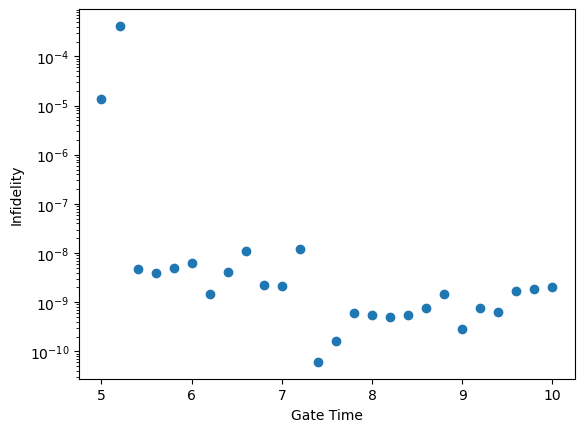

In [14]:
plt.semilogy(gate_times, fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Infidelity")

## Save Results

In [13]:
# save results
import pickle

# with open("results/goat_run_16.pkl", "wb") as f:
#     pickle.dump((res, prev_params), f)

with open("results/time_sweep_1.pkl", "wb") as f:
    pickle.dump((gate_times, goat_results, fidelities), f)

In [ ]:
# exporting to pulse format for qutip simulations
with open("results/goat_run_13.pkl", "rb") as file:
    (loaded_res, loaded_prev_params) = pickle.load(file)

times = np.linspace(0, t_max, n_pieces)
phases = loaded_res.x[:-1]
Omegas = control_extra_params["Omega_max"] * np.ones(n_pieces)


np.savetxt("pulses/goat_gate4_best.csv", np.column_stack((times, Omegas, phases)), delimiter=",", header="t,|Omega|,arg(Omega)")